## I. Perkenalan
Nama : Fadhilah Amani Alam Aulia

Batch : 015-RMT

Dataset : Waste Classification Data

Objective : Mengklasikasi gambar sampah menjadi kategori 'Organic (O)' dan 'Recyclable (R)'

## II. Import Libraries

In [2]:
# Mengimport library yang dibutuhkan

import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, Flatten, Input
from tensorflow.keras import Model

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from google.colab import files

import warnings
warnings.filterwarnings('ignore')

## III. Data Loading

In [3]:
# Membuat folder kaggle di root

!mkdir -p ~/.kaggle

# Copy file ke folder

!cp kaggle.json ~/.kaggle

# Membuat folder kaggle

!mkdir ./kaggle

# Memindahkan file kaggle.json ke folder kaggle

!mv ./kaggle.json ./kaggle

In [4]:
# Membuat akses hanya untuk pemilik file

!chmod 600 ~/.kaggle/kaggle.json

# Mengecek file apa saja yang tedapat pada folder kaggle

!ls ~/.kaggle

kaggle.json


In [5]:
# Download file dataset dari kaggle

!kaggle datasets download -d techsash/waste-classification-data

 98% 417M/427M [00:11<00:00, 45.6MB/s]
100% 427M/427M [00:11<00:00, 40.5MB/s]


In [6]:
# Unzip dataset sebagai folder images

!unzip -q /content/waste-classification-data.zip -d images

In [7]:
# Mengecek list folder pada dataset

os.listdir('/content/images/DATASET')

['TEST', 'TRAIN']

In [8]:
# Membuat path untuk folder train dan test

mypath = '/content/images/DATASET'
train_dir = os.path.join(mypath, 'TRAIN')
test_dir = os.path.join(mypath, 'TEST')

In [9]:
# Mengubah nama folder 'O' menjadi 'Organic' dan 'R' menjadi 'Recyclable'

!mv /content/images/DATASET/TRAIN/O /content/images/DATASET/TRAIN/Organic
!mv /content/images/DATASET/TRAIN/R /content/images/DATASET/TRAIN/Recyclable

!mv /content/images/DATASET/TEST/O /content/images/DATASET/TEST/Organic
!mv /content/images/DATASET/TEST/R /content/images/DATASET/TEST/Recyclable

In [10]:
# Mengecek jumlah data pada folder TRAIN

print('Data Train Set: \n' + '-'*50)
num_o= len(os.listdir(os.path.join(train_dir, 'Organic')))
num_r= len(os.listdir(os.path.join(train_dir, 'Recyclable')))
print(f'jumlah data organic = {num_o}')
print(f'jumlah data recyclable = {num_r}')
print('='*50)

# Mengecek jumlah data pada folder TEST

print('Data Test Set: \n' + '-'*50)
num_o1= len(os.listdir(os.path.join(test_dir, 'Organic')))
num_r1= len(os.listdir(os.path.join(test_dir, 'Recyclable')))
print(f'jumlah data organic = {num_o1}')
print(f'jumlah data recyclable = {num_r1}')

Data Train Set: 
--------------------------------------------------
jumlah data organic = 12565
jumlah data recyclable = 9999
Data Test Set: 
--------------------------------------------------
jumlah data organic = 1401
jumlah data recyclable = 1112


In [11]:
# Membuat dataframe untuk data train dan data test

train_o = glob.glob(train_dir+"/Organic/*.jpg")
train_r = glob.glob(train_dir+"/Recyclable/*.jpg")

test_o = glob.glob(test_dir+"/Organic/*.jpg")
test_r = glob.glob(test_dir+"/Recyclable/*.jpg")
 
def create_dataframe(list_of_images):
    data = []
    for image in list_of_images:
        data.append((image, image.split('/')[-2]))
    return pd.DataFrame(data, columns=['images', 'label'])

train_df = create_dataframe(train_o + train_r)
train_df = train_df.sample(frac=1, random_state=6).reset_index(drop=True)

test_df = create_dataframe(test_o + test_r)
test_df = test_df.sample(frac=1, random_state=6).reset_index(drop=True)

In [12]:
# Mengecek jumlah data train

print(train_df.shape)

# Menampilkan 10 baris pertama pada data train

train_df.head(10)

(22564, 2)


,images,label
0,/content/images/DATASET/TRAIN/Recyclable/R_170...,Recyclable
1,/content/images/DATASET/TRAIN/Recyclable/R_669...,Recyclable
2,/content/images/DATASET/TRAIN/Recyclable/R_676...,Recyclable
3,/content/images/DATASET/TRAIN/Organic/O_2369.jpg,Organic
4,/content/images/DATASET/TRAIN/Organic/O_7016.jpg,Organic
5,/content/images/DATASET/TRAIN/Recyclable/R_306...,Recyclable
6,/content/images/DATASET/TRAIN/Recyclable/R_921...,Recyclable
7,/content/images/DATASET/TRAIN/Organic/O_6955.jpg,Organic
8,/content/images/DATASET/TRAIN/Recyclable/R_727...,Recyclable
9,/content/images/DATASET/TRAIN/Recyclable/R_689...,Recyclable


In [13]:
# Mengecek jumlah data test

print(test_df.shape)

# Menampilkan 10 baris pertama pada data test

test_df.head(10)

(2513, 2)


,images,label
0,/content/images/DATASET/TEST/Recyclable/R_1071...,Recyclable
1,/content/images/DATASET/TEST/Organic/O_12809.jpg,Organic
2,/content/images/DATASET/TEST/Recyclable/R_1072...,Recyclable
3,/content/images/DATASET/TEST/Recyclable/R_1033...,Recyclable
4,/content/images/DATASET/TEST/Organic/O_13679.jpg,Organic
5,/content/images/DATASET/TEST/Organic/O_13422.jpg,Organic
6,/content/images/DATASET/TEST/Organic/O_13058.jpg,Organic
7,/content/images/DATASET/TEST/Organic/O_12697.jpg,Organic
8,/content/images/DATASET/TEST/Organic/O_12957.jpg,Organic
9,/content/images/DATASET/TEST/Recyclable/R_1011...,Recyclable


Karena dataset ini hanya dibagi menjadi dataset train dan test, maka untuk dataset val akan diambil dari dataset train sebanyak 20%.

In [14]:
# Membagi data train dan data val

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=6, stratify = train_df['label'])
print('Data train : ', train_df.shape)
print('Data val: ', val_df.shape)
print('Data test: ', test_df.shape)

# Menampilkan 10 baris pertama pada data val

val_df.head(10)

Data train :  (18051, 2)
Data val:  (4513, 2)
Data test:  (2513, 2)


,images,label
6887,/content/images/DATASET/TRAIN/Organic/O_10532.jpg,Organic
14542,/content/images/DATASET/TRAIN/Recyclable/R_223...,Recyclable
15169,/content/images/DATASET/TRAIN/Recyclable/R_248...,Recyclable
21513,/content/images/DATASET/TRAIN/Organic/O_7347.jpg,Organic
6451,/content/images/DATASET/TRAIN/Organic/O_1082.jpg,Organic
14934,/content/images/DATASET/TRAIN/Organic/O_4482.jpg,Organic
16545,/content/images/DATASET/TRAIN/Recyclable/R_933...,Recyclable
1873,/content/images/DATASET/TRAIN/Organic/O_2309.jpg,Organic
7473,/content/images/DATASET/TRAIN/Recyclable/R_782...,Recyclable
21261,/content/images/DATASET/TRAIN/Organic/O_3378.jpg,Organic


In [15]:
# Mengecek info dataset

print('Data Train Set: \n' + '-'*50)
train_df.info()
print('='*50)
print('\nData Val Set: \n' + '-'*50)
val_df.info()
print('='*50)
print('\nData Test Set: \n' + '-'*50)
test_df.info()

Data Train Set: 
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18051 entries, 11014 to 10079
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  18051 non-null  object
 1   label   18051 non-null  object
dtypes: object(2)
memory usage: 423.1+ KB

Data Val Set: 
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4513 entries, 6887 to 8380
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  4513 non-null   object
 1   label   4513 non-null   object
dtypes: object(2)
memory usage: 105.8+ KB

Data Test Set: 
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2513 entries, 0 to 2512
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  2513 non-null

Berdasarkan data di atas, dapat diketahui bahwa data train memiliki 18051 data, data val memiliki 4513 data, dan data test memiliki 2513 data. Ketiga dataset tersebut memiliki dua kolom, yaitu images dan label.

## IV. Exploratory Data Analysis (EDA)

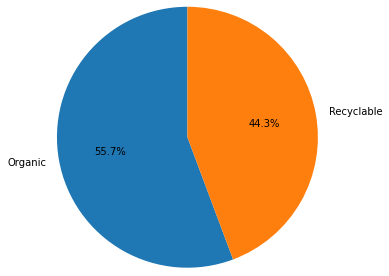

In [16]:
# Visualisasi keseluruhan data kategori 'Organic' dan 'Recyclable'

all_df = pd.concat([train_df, val_df, test_df], axis=0)
# colors = ['#a0d157','#c48bb8']
plt.pie(all_df.label.value_counts(),startangle=90,autopct='%0.1f%%',
        labels=['Organic', 'Recyclable'],radius=1.5)
plt.show()

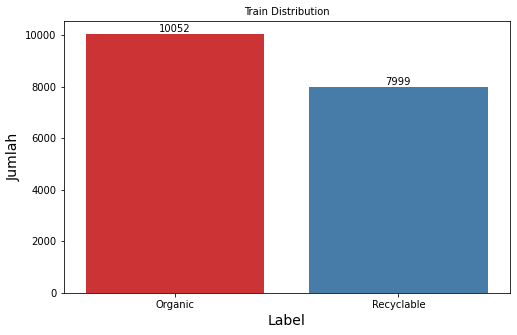

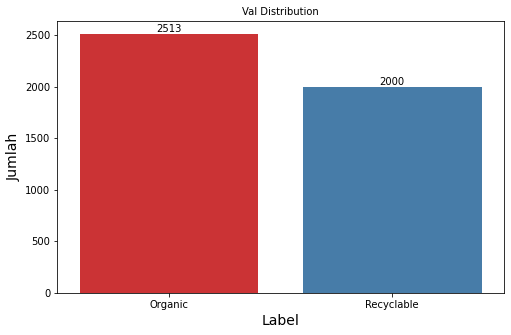

In [67]:
# Visualisasi jumlah data Organic dan Recyclable pada data Train

def visualize_data(dataframe, label):
    fig, ax = plt.subplots(figsize =(8, 5))
    ax = sns.countplot(x='label', data=dataframe, palette='Set1')
    ax.set_title('Data Distribution')
    ax.set_xlabel('Label')
    ax.set_ylabel('Count')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2,
                    p.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 5),
                   textcoords='offset points')
    
    plt.xlabel("Label", size=14)
    plt.ylabel("Jumlah", size=14)
    plt.title(f"{label} Distribution", size=10)
    plt.show()

visualize_data(train_df, 'Train')
visualize_data(val_df, 'Val')

Berdasarkan data di atas, dapat diketahui bahwa keseluruhan dataset ini memiliki 55.7% gambar Organic dan 44.3% gambar Recyclable. Data Train memiliki 10052 gambar Organic dan 7999 gambar Recyclable, sedangkan untuk data Val memiliki 2513 gambar Organic dan 2000 gambar Recyclable.

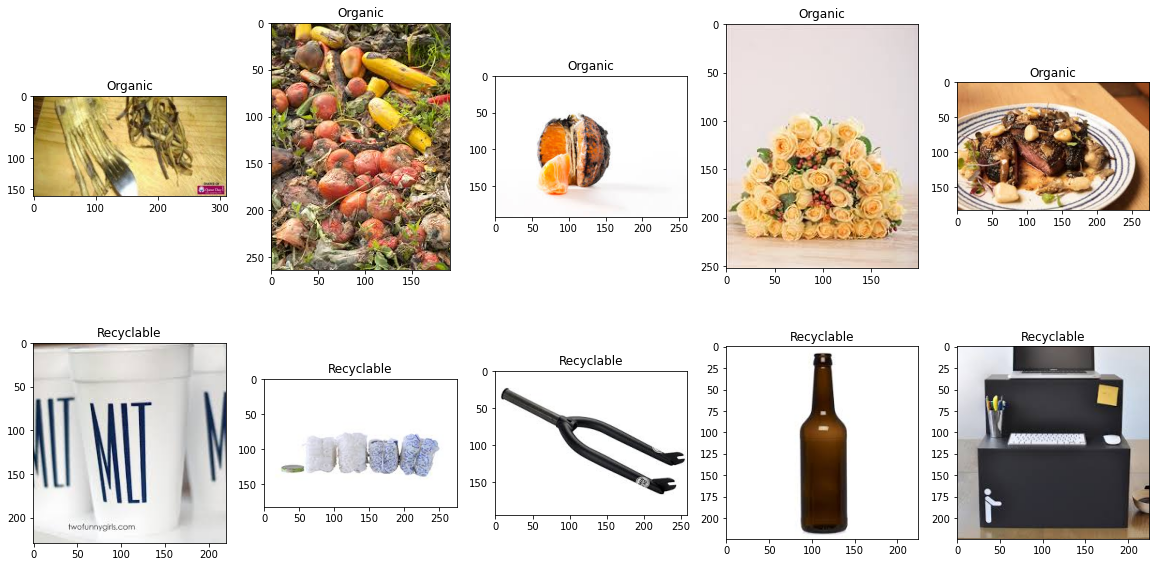

In [79]:
# Menampilkan beberapa gambar dari kategori Organic dan Recyclable

organic_samples = (train_df[train_df['label']=='Organic']['images'].iloc[:5]).tolist()
recyclable_samples = (train_df[train_df['label']=='Recyclable']['images'].iloc[:5]).tolist()

def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
    for i, sample in enumerate(samples):
        img = cv2.imread(sample)
        ax[i//5, i%5].set_title(sample.split('/')[-2])
        ax[i//5, i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

visualize_samples(organic_samples + recyclable_samples)

In [19]:
# Membuat gambar menjadi matrix

def img2np(path, list_of_filename, size = (64, 64)):
    for fn in list_of_filename:
        fp = fn
        current_image = image.load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        img_ts = image.img_to_array(current_image)
        img_ts = [img_ts.ravel()]
        try:
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            full_mat = img_ts
    return full_mat

org_images = img2np(f'{train_dir}/Organic/', organic_samples)
rcy_images = img2np(f'{train_dir}/Recyclable/', recyclable_samples)

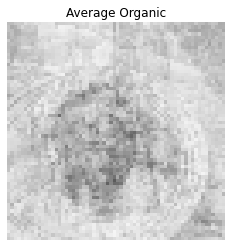

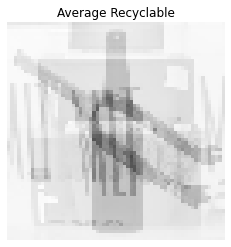

In [20]:
# Melihat rata-rata gambar dari setiap kelas

def find_mean_img(full_mat, title, size = (64, 64)):
    mean_img = np.mean(full_mat, axis = 0)
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

org_mean = find_mean_img(org_images, 'Organic')
rcy_mean = find_mean_img(rcy_images, 'Recyclable')

- Berdasarkan data gambar sample di atas, dapat diketahui bahwa data kelas Organic terdiri dari gambar-gambar buah, bunga, dan tumbuh-tumbuhan. Sedangkan untuk data kelas Recyclable, terdiri dari gambar-gambar botol, plastik, dan gelas. 
- Lalu ketika gambar sample dirata-ratakan, kelas Organic dan Recyclable menjadi tidak teridentifikasi. Hal ini dapat disebabkan karena dataset memiliki gambar yang objeknya beragam, tidak hanya satu objek yang identik sama.
- Selain itu, dapat dilihat bahwa ukuran dari masing-masing gambar pada kelas Organic dan Recyclable berbeda-beda. Ukuran gambar ini nantinya akan diatur kembali pada bagian data preprocessing. 

## V. Data Preprocessing
Pada bagian data preprocessing, akan dilakukan Augmentasi pada gambar. Hal ini dilakukan agar gambar menjadi lebih bervariasi, sehingga hasil modeling akan menjadi lebih baik. Augmentasi yang akan dilakukan pada dataset ini adalah rotation, width, height, shear, zoom, dan horizontal flip.

In [21]:
# Mengatur ukuran gambar

img_height= 220
img_width= 220
SEED = 1
BATCH =64

In [22]:
# Augmentasi Gambar

train_dg = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_dg = ImageDataGenerator(rescale=1./255)
test_dg = ImageDataGenerator(rescale=1./255)

In [23]:
# Mengatur augmentasi pada data train, val, dan test

train_set = train_dg.flow_from_dataframe(
    dataframe=train_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=BATCH,
    shuffle=True,
    seed=SEED)

val_set = val_dg.flow_from_dataframe(
    dataframe=val_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

test_set = test_dg.flow_from_dataframe(
    dataframe=test_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

Found 18051 validated image filenames belonging to 2 classes.
Found 4513 validated image filenames belonging to 2 classes.
Found 2513 validated image filenames belonging to 2 classes.


In [24]:
# Menentukan kelas pada data

train_set.class_indices

{'Organic': 0, 'Recyclable': 1}

## Sequential API

### VI.1 Model Definition

In [25]:
# Mendefinisikan model yang digunakan

inputs = [img_height, img_width, 3]

model_seq = Sequential()

#Conv1
model_seq.add(Conv2D(filters=16, kernel_size=3, activation='relu', padding='same',input_shape=inputs))
model_seq.add(MaxPooling2D())

#Conv2
model_seq.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
model_seq.add(MaxPooling2D())

#Conv3
model_seq.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
model_seq.add(MaxPooling2D())

model_seq.add(Flatten())
model_seq.add(Dense(units= 128, activation='relu'))
model_seq.add(Dense(units=64, activation='relu'))
model_seq.add(Dense(units=1, activation='sigmoid'))

In [26]:
# Compile Model

model_seq.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [27]:
# Summary Model

model_seq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 55, 55, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 27, 27, 64)       0

### VII.1 Model Training

In [28]:
# Melakukan training pada model

history_seq= model_seq.fit(train_set, batch_size= BATCH, epochs= 10, validation_data= val_set)

Epoch 1/10
283/283 [==============================] - 198s 666ms/step - loss: 0.4502 - accuracy: 0.7999 - val_loss: 0.3967 - val_accuracy: 0.8243
Epoch 2/10
283/283 [==============================] - 187s 662ms/step - loss: 0.3886 - accuracy: 0.8329 - val_loss: 0.3609 - val_accuracy: 0.8400
Epoch 3/10
283/283 [==============================] - 188s 666ms/step - loss: 0.3594 - accuracy: 0.8487 - val_loss: 0.3377 - val_accuracy: 0.8555
Epoch 4/10
283/283 [==============================] - 188s 664ms/step - loss: 0.3440 - accuracy: 0.8583 - val_loss: 0.3339 - val_accuracy: 0.8604
Epoch 5/10
283/283 [==============================] - 187s 659ms/step - loss: 0.3390 - accuracy: 0.8596 - val_loss: 0.3352 - val_accuracy: 0.8595
Epoch 6/10
283/283 [==============================] - 187s 660ms/step - loss: 0.3322 - accuracy: 0.8654 - val_loss: 0.3214 - val_accuracy: 0.8724
Epoch 7/10
283/283 [==============================] - 187s 660ms/step - loss: 0.3213 - accuracy: 0.8693 - val_loss: 0.3208 -

### VIII.1 Model Evaluation

In [29]:
# Membuat dataframe untuk hasil history_seq

history_seq_df = pd.DataFrame(history_seq.history)
history_seq_df

,loss,accuracy,val_loss,val_accuracy
0,0.450186,0.799900,0.396750,0.824285
1,0.388589,0.832862,0.360940,0.840018
2,0.359420,0.848706,0.337715,0.855528
3,0.344001,0.858290,0.333942,0.860403
4,0.339043,0.859620,0.335166,0.859517
5,0.332225,0.865381,0.321361,0.872369
6,0.321315,0.869259,0.320832,0.868159
7,0.317872,0.869592,0.342228,0.861511
8,0.307825,0.875353,0.295070,0.874806
9,0.307062,0.874301,0.300083,0.881454


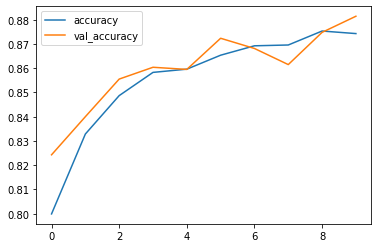

In [30]:
# Grafik Accuracy Train dan Validation

history_seq_df[['accuracy', 'val_accuracy']].plot()

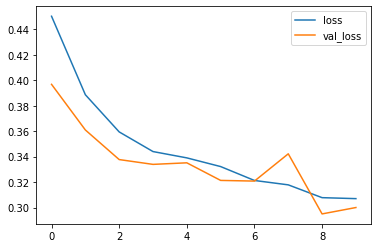

In [31]:
# Grafik Loss Train dan Validation

history_seq_df[['loss', 'val_loss']].plot()

In [32]:
# Evaluasi model untuk data test

loss, acc = model_seq.evaluate(test_set)
print('Accuracy on training data: {:.4f} \nLoss on training data: {:.4f}'.format(acc,loss),'\n')

40/40 [==============================] - 5s 113ms/step - loss: 0.2623 - accuracy: 0.9013
Accuracy on training data: 0.9013 
Loss on training data: 0.2623 



---
### Model Improvement
Pada bagian improvement, akan dilakukan penggunaan MaxPooling2D, Dropout, dan EarlyStopping untuk meningkatkan hasil akurasi model menjadi lebih baik. EarlyStopping akan menghentikan model training untuk mencegah model overfit.

In [33]:
# Mendefinisikan model yang digunakan

inputs = [img_height, img_width, 3]

model_seq1 = Sequential()

#Conv1
model_seq1.add(Conv2D(filters=16, kernel_size=3, activation='relu', padding='same',input_shape=inputs))
model_seq1.add(MaxPooling2D(pool_size=2, strides=2))

#Conv2
model_seq1.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
model_seq1.add(MaxPooling2D(pool_size=2, strides=2))

#Conv3
model_seq1.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
model_seq1.add(MaxPooling2D(pool_size=2, strides=2))

model_seq1.add(Flatten())
model_seq1.add(Dense(units= 128, activation='relu'))
model_seq1.add(Dropout(rate=0.1))
model_seq1.add(Dense(units=64, activation='relu'))
model_seq1.add(Dropout(rate=0.1))
model_seq1.add(Dense(units=1, activation='sigmoid'))

In [34]:
# Compile Model

model_seq1.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [35]:
# Summary Model

model_seq1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 220, 220, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 110, 110, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 110, 110, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 55, 55, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 27, 27, 64)      

In [36]:
# Melakukan training pada model

history_seq1 = model_seq1.fit(train_set, batch_size= BATCH, epochs= 10, validation_data= val_set, callbacks= EarlyStopping(monitor = 'val_loss', patience = 3))

Epoch 1/10
283/283 [==============================] - 188s 662ms/step - loss: 0.4462 - accuracy: 0.8020 - val_loss: 0.3955 - val_accuracy: 0.8298
Epoch 2/10
283/283 [==============================] - 185s 655ms/step - loss: 0.3907 - accuracy: 0.8339 - val_loss: 0.3566 - val_accuracy: 0.8462
Epoch 3/10
283/283 [==============================] - 185s 653ms/step - loss: 0.3665 - accuracy: 0.8462 - val_loss: 0.3446 - val_accuracy: 0.8586
Epoch 4/10
283/283 [==============================] - 185s 654ms/step - loss: 0.3540 - accuracy: 0.8513 - val_loss: 0.4063 - val_accuracy: 0.8170
Epoch 5/10
283/283 [==============================] - 185s 653ms/step - loss: 0.3400 - accuracy: 0.8603 - val_loss: 0.3343 - val_accuracy: 0.8662
Epoch 6/10
283/283 [==============================] - 186s 657ms/step - loss: 0.3278 - accuracy: 0.8667 - val_loss: 0.3069 - val_accuracy: 0.8784
Epoch 7/10
283/283 [==============================] - 185s 653ms/step - loss: 0.3289 - accuracy: 0.8647 - val_loss: 0.3305 -

In [37]:
# Membuat dataframe untuk hasil history_seq

history_seq1_df = pd.DataFrame(history_seq1.history)
history_seq1_df

,loss,accuracy,val_loss,val_accuracy
0,0.446163,0.802005,0.395541,0.829825
1,0.390663,0.833860,0.356619,0.846222
2,0.366485,0.846214,0.344563,0.858631
3,0.354032,0.851310,0.406317,0.816973
4,0.339999,0.860340,0.334276,0.866164
5,0.327845,0.866711,0.306911,0.878351
6,0.328928,0.864661,0.330475,0.862397
7,0.319162,0.871087,0.311587,0.874363
8,0.311026,0.874190,0.301499,0.877465
9,0.312786,0.872029,0.312535,0.879681


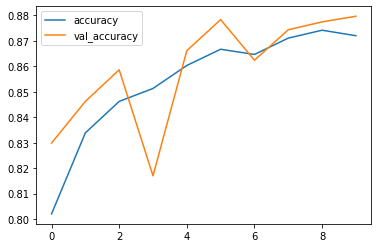

In [38]:
# Grafik Accuracy Train dan Validation

history_seq1_df[['accuracy', 'val_accuracy']].plot()

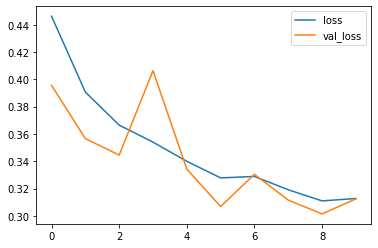

In [39]:
# Grafik Loss Train dan Validation

history_seq1_df[['loss', 'val_loss']].plot()

In [40]:
# Evaluasi model untuk data test

loss, acc = model_seq1.evaluate(test_set)
print('Accuracy on training data: {:.4f} \nLoss on training data: {:.4f}'.format(acc,loss))

40/40 [==============================] - 4s 108ms/step - loss: 0.2452 - accuracy: 0.9065
Accuracy on training data: 0.9065 
Loss on training data: 0.2452


## Functional API

### VI.2 Model Definition

In [41]:
# Mendefinisikan model yang digunakan

img_inputs = Input(shape=(img_height, img_width, 3))

conv1 = Conv2D(filters=16, kernel_size=3, activation='relu', padding='same')(img_inputs)
maxpool1 = MaxPooling2D()(conv1)

conv2 = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(maxpool1)
maxpool2 = MaxPooling2D()(conv2)

conv3 = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(maxpool2)
maxpool3 = MaxPooling2D()(conv3)

flatten = Flatten()(maxpool3)
dense1 = Dense(units=128, activation='relu') (flatten)
dense2 = Dense(units=64, activation='relu') (dense1)
out_l = Dense(units=1, activation='sigmoid') (dense2)

model_func = Model(inputs = img_inputs, outputs = out_l)

In [42]:
# Compile model

model_func.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [43]:
# Summary model

model_func.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 220, 220, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 220, 220, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 110, 110, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 110, 110, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 55, 55, 64)        18496 

### VII.2 Model Training

In [44]:
# Melakukan training pada model

history_func= model_func.fit(train_set, batch_size= BATCH, epochs= 10, validation_data= val_set)

Epoch 1/10
283/283 [==============================] - 186s 656ms/step - loss: 0.4423 - accuracy: 0.8024 - val_loss: 0.3891 - val_accuracy: 0.8340
Epoch 2/10
283/283 [==============================] - 185s 655ms/step - loss: 0.3871 - accuracy: 0.8352 - val_loss: 0.3911 - val_accuracy: 0.8278
Epoch 3/10
283/283 [==============================] - 186s 656ms/step - loss: 0.3602 - accuracy: 0.8469 - val_loss: 0.3786 - val_accuracy: 0.8289
Epoch 4/10
283/283 [==============================] - 185s 652ms/step - loss: 0.3469 - accuracy: 0.8547 - val_loss: 0.3204 - val_accuracy: 0.8631
Epoch 5/10
283/283 [==============================] - 184s 651ms/step - loss: 0.3329 - accuracy: 0.8610 - val_loss: 0.3228 - val_accuracy: 0.8675
Epoch 6/10
283/283 [==============================] - 185s 653ms/step - loss: 0.3180 - accuracy: 0.8712 - val_loss: 0.3177 - val_accuracy: 0.8671
Epoch 7/10
283/283 [==============================] - 184s 652ms/step - loss: 0.3154 - accuracy: 0.8700 - val_loss: 0.3388 -

### VIII.2 Model Evaluation

In [45]:
# Membuat dataframe untuk hasil history_func

history_func_df = pd.DataFrame(history_func.history)
history_func_df

,loss,accuracy,val_loss,val_accuracy
0,0.442293,0.802449,0.389064,0.834035
1,0.387120,0.835189,0.391145,0.827831
2,0.360247,0.846934,0.378629,0.828939
3,0.346851,0.854745,0.320361,0.863062
4,0.332945,0.861005,0.322843,0.867494
5,0.318046,0.871198,0.317653,0.867051
6,0.315406,0.870035,0.338808,0.859960
7,0.300936,0.875796,0.289752,0.880567
8,0.298678,0.879176,0.283698,0.885220
9,0.295237,0.881336,0.317864,0.874806


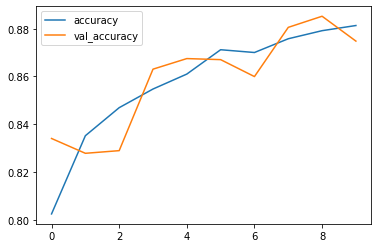

In [46]:
# Grafik Accuracy Train dan Validation

history_func_df[['accuracy', 'val_accuracy']].plot()

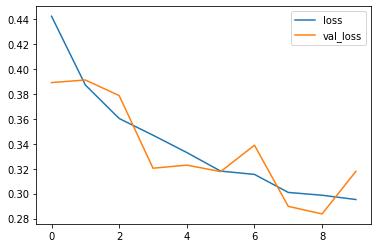

In [47]:
# Grafik Loss Train dan Validation

history_func_df[['loss', 'val_loss']].plot()

In [48]:
# Evaluasi model untuk data test

loss, acc = model_func.evaluate(test_set, verbose=0)
print('Accuracy on training data: {:.4f} \nLoss on training data: {:.4f}'.format(acc,loss))

Accuracy on training data: 0.8989 
Loss on training data: 0.2589


---
### Model Improvement
Pada bagian improvement, akan dilakukan penggunaan MaxPooling2D, Dropout, dan EarlyStopping untuk meningkatkan hasil akurasi model menjadi lebih baik. EarlyStopping akan menghentikan model training untuk mencegah model overfit.

In [49]:
# Mendefinisikan model yang digunakan

img_inputsA = Input(shape=(img_height, img_width, 3))

conv1A = Conv2D(filters=16, kernel_size=3, activation='relu', padding='same')(img_inputsA)
maxpool1A = MaxPooling2D(pool_size=2, strides=2)(conv1A)

conv2A = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(maxpool1A)
maxpool2A = MaxPooling2D(pool_size=2, strides=2)(conv2A)

conv3A = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(maxpool2A)
maxpool3A = MaxPooling2D(pool_size=2, strides=2)(conv3A)

flattenA = Flatten()(maxpool3A)
dense1A = Dense(units=128, activation='relu') (flattenA)
drop1A = Dropout(rate=0.1) (dense1A)
dense2A = Dense(units=64, activation='relu') (drop1A)
drop2A = Dropout(rate=0.1) (dense2A)
out_lA = Dense(units=1, activation='sigmoid') (drop2A)

model_func1 = Model(inputs = img_inputsA, outputs = out_lA)

In [50]:
# Compile model

model_func1.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [51]:
# Summary model

model_func1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 220, 220, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 220, 220, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 110, 110, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 110, 110, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 55, 55, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 55, 55, 64)        1849

In [52]:
# Melakukan training pada model

history_func1= model_func1.fit(train_set, batch_size= BATCH, epochs= 10, validation_data= val_set, callbacks= EarlyStopping(monitor = 'val_loss', patience = 3))

Epoch 1/10
283/283 [==============================] - 186s 655ms/step - loss: 0.4660 - accuracy: 0.7911 - val_loss: 0.4114 - val_accuracy: 0.8254
Epoch 2/10
283/283 [==============================] - 185s 655ms/step - loss: 0.4007 - accuracy: 0.8263 - val_loss: 0.3675 - val_accuracy: 0.8413
Epoch 3/10
283/283 [==============================] - 185s 655ms/step - loss: 0.3662 - accuracy: 0.8461 - val_loss: 0.3469 - val_accuracy: 0.8586
Epoch 4/10
283/283 [==============================] - 185s 653ms/step - loss: 0.3462 - accuracy: 0.8558 - val_loss: 0.3314 - val_accuracy: 0.8655
Epoch 5/10
283/283 [==============================] - 186s 658ms/step - loss: 0.3479 - accuracy: 0.8559 - val_loss: 0.3473 - val_accuracy: 0.8582
Epoch 6/10
283/283 [==============================] - 185s 653ms/step - loss: 0.3285 - accuracy: 0.8634 - val_loss: 0.3391 - val_accuracy: 0.8498
Epoch 7/10
283/283 [==============================] - 184s 652ms/step - loss: 0.3257 - accuracy: 0.8672 - val_loss: 0.3076 -

In [53]:
# Membuat dataframe untuk hasil history_seq

history_func1_df = pd.DataFrame(history_func1.history)
history_func1_df

,loss,accuracy,val_loss,val_accuracy
0,0.465977,0.791092,0.411427,0.825393
1,0.400688,0.826270,0.367484,0.841347
2,0.366205,0.846103,0.346911,0.858631
3,0.346237,0.855797,0.331394,0.865500
4,0.347859,0.855853,0.347279,0.858187
5,0.328483,0.863387,0.339149,0.849767
6,0.325657,0.867154,0.307562,0.876136
7,0.319599,0.869536,0.320444,0.879459
8,0.318135,0.870035,0.306180,0.878573
9,0.308807,0.873359,0.315354,0.875249


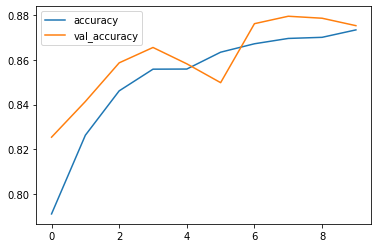

In [54]:
# Grafik Accuracy Train dan Validation

history_func1_df[['accuracy', 'val_accuracy']].plot()

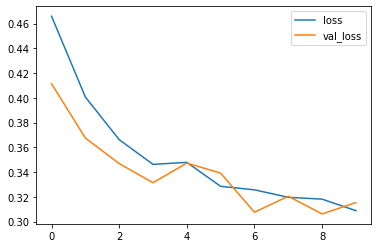

In [55]:
# Grafik Loss Train dan Validation

history_func1_df[['loss', 'val_loss']].plot()

In [56]:
# Evaluasi model untuk data test

loss, acc = model_func1.evaluate(test_set)
print('Accuracy on training data: {:.4f} \nLoss on training data: {:.4f}'.format(acc,loss))

40/40 [==============================] - 4s 111ms/step - loss: 0.2485 - accuracy: 0.9033
Accuracy on training data: 0.9033 
Loss on training data: 0.2485


Berdasarkan nilai akurasi pada masing-masing model, model dengan nilai akurasi tertinggi adalah model Sequential Improvement dengan nilai akurasi 91%. Maka model Sequential Improvement akan disimpan untuk digunakan pada model inference.

In [60]:
# Freeze model

model_seq1.trainable = False

# Display Summary

model_seq1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 220, 220, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 110, 110, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 110, 110, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 55, 55, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 27, 27, 64)      

# IX. Model Saving

In [61]:
# Menyimpan model terbaik

model_seq1.save('classification_model.hdf5')
model_seq1.save('classification_model')
! zip -r classification_model.zip classification_model

  adding: classification_model/ (stored 0%)
  adding: classification_model/keras_metadata.pb (deflated 92%)
  adding: classification_model/variables/ (stored 0%)
  adding: classification_model/variables/variables.data-00000-of-00001 (deflated 20%)
  adding: classification_model/variables/variables.index (deflated 67%)
  adding: classification_model/saved_model.pb (deflated 89%)
  adding: classification_model/assets/ (stored 0%)


# X. Model Inference

Saving 1662466486.jpg to 1662466486 (5).jpg


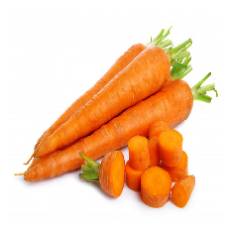

1/1 [==============================] - 0s 22ms/step
[[0.]]
Organic


Saving 630433_29-10-2019_13-1-49.jpg to 630433_29-10-2019_13-1-49 (3).jpg


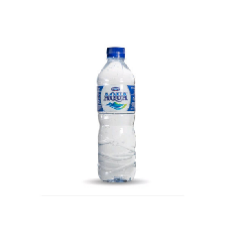

1/1 [==============================] - 0s 16ms/step
[[1.]]
Recyclable


In [74]:
# Melakukan testing

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(220,220))
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model_seq1.predict(images)
  print(classes) 
  if classes[0][0] == 1:
    print('Recyclable')
  else:
    print('Organic')

uploaded1 = files.upload()

for fn1 in uploaded1.keys():
  path1 = fn1
  img1 = image.load_img(path1, target_size=(220,220))
  plt.imshow(img1)
  plt.axis('Off')
  plt.show()
  x1 = image.img_to_array(img1)
  x1 = np.expand_dims(x1, axis=0)

  images1 = np.vstack([x1])
  classes1 = model_seq1.predict(images1)
  print(classes1) 
  if classes1[0][0] == 1:
    print('Recyclable')
  else:
    print('Organic')

# XI. Pengambilan Kesimpulan
Berdasarkan data-data di atas, dapat disimpulkan bahwa:
- Dataset ini hanya terdiri atas data Train dan Test, maka dari itu akan diambil data Train sebesar 20% untuk data Val.
- Keseluruhan dataset ini memiliki 55.7% gambar Organic dan 44.3% gambar Recyclable. 
- Data Train memiliki 10052 gambar Organic dan 7999 gambar Recyclable, sedangkan untuk data Val memiliki 2513 gambar Organic dan 2000 gambar Recyclable.
- Model yang digunakan adalah Model Sequential API dan Functional API.
- Pada model Sequential API, setelah dilakukan improvement pada model tingkat akurasi pada model meningkat sebesar 1%, dari 90% menjadi 91%. Sedangkan pada model Functional API, setelah dilakukan improvement, tingkat akurasi pada model juga meningkat sebesar 1%, dari 89% menjadi 90%.
- Hasil testing bekerja dengan baik. Model dapat melakukan klasifikasi gambar dengan benar. Tetapi jika dilakukan upload gambar yang bertipe kartun, maka kemungkinan besar model akan salah mengklasifikasi. Hal ini bisa disebabkan karena pada saat dilakukan training, data gambar yang digunakan adalah gambar real, bukan kartun.
- Untuk memperbaiki model yang telah dibuat, bisa dengan menambahkan parameter yang digunakan dan menerapkan penggunaan kamera untuk memprediksi kelas gambar. Sehingga user tidak perlu harus mengupload gambar terlebih dahulu, tetapi bisa langsung memprediksi kelas gamabr hanya dengan menunjukkan pada kamera.